In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import io, base64, os, json, re 
import pandas as pd
import numpy as np
import datetime
from sklearn.linear_model import LinearRegression
import seaborn as sns
import yfinance as yf
import datetime as dt
import fredapi as fa
from scipy.stats import linregress

fred = fa.Fred(api_key = 'c5c2287d62d19f69642865b0b0a950fa')

C:\Users\fdoba\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\fdoba\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\fdoba\anaconda3\lib\site-packages\numpy\.libs\libopenblas.gk7gx5keq4f6uyo3p26ulgbqyhgqo7j4.gfortran-win_amd64.dll
C:\Users\fdoba\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### Download the prices for GOLD stocks/ETF - Timeframe: Monthly

In [2]:
begin_date = datetime.datetime(2009,1,1)
end_date = datetime.datetime(2022,10,31)

gold_list = ["GLD","ASM","GOLD","NGD"]
df_prices = yf.download(gold_list,start = begin_date,end=end_date,interval='1mo')
df_prices = round(df_prices['Adj Close'],2)
df_prices.reset_index(inplace=True)
df_prices['Date'] = pd.to_datetime(df_prices['Date']).dt.date
df_prices.set_index('Date',inplace=True)
df_prices.dropna(inplace=True)

[*********************100%***********************]  4 of 4 completed


### Download CPI

In [3]:
df_cpi = pd.DataFrame()
cpi = fred.get_series('CPIAUCNS')
df_cpi['date'] = pd.to_datetime(cpi.index)
df_cpi['cpi'] = cpi.values
df_cpi.dropna(inplace=True)
df_cpi = df_cpi[df_cpi['date'] >= begin_date]
df_cpi.head()

,date,cpi
1152,2009-01-01,211.143
1153,2009-02-01,212.193
1154,2009-03-01,212.709
1155,2009-04-01,213.240
1156,2009-05-01,213.856


In [4]:
df_prices['CPI'] = df_cpi['cpi'].values

### Calculating the gold and CPI returns

In [5]:
df_returns = round(df_prices.pct_change() * 100,2)
df_returns.dropna(inplace=True)
df_returns.tail()

,ASM,GLD,GOLD,NGD,CPI
Date,,,,,
2022-06-01,-22.86,-1.57,-12.83,-15.75,1.37
2022-07-01,16.67,-2.59,-11.05,-23.36,-0.01
2022-08-01,-14.29,-2.94,-5.60,-20.73,-0.04
2022-09-01,-5.56,-2.89,5.73,35.38,0.22
2022-10-01,19.61,-1.78,-3.03,1.14,0.41


## Correlation

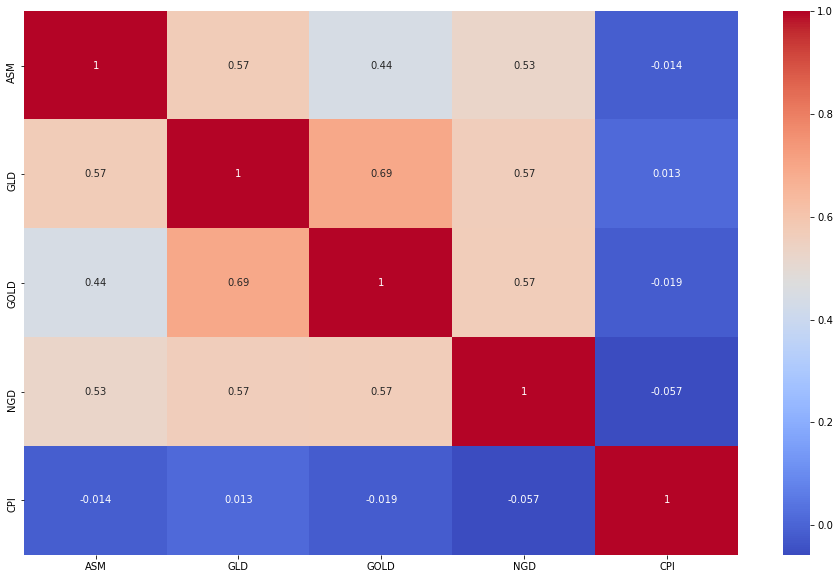

In [6]:
gold_corr = df_returns.corr(method="pearson")
fig, ax = plt.subplots(figsize=(16,10))
sns.heatmap(gold_corr,annot=True,cmap="coolwarm")
plt.show()

### There's no good correlation between the gold stocks and CPI

### Analyzing the Linear Regression

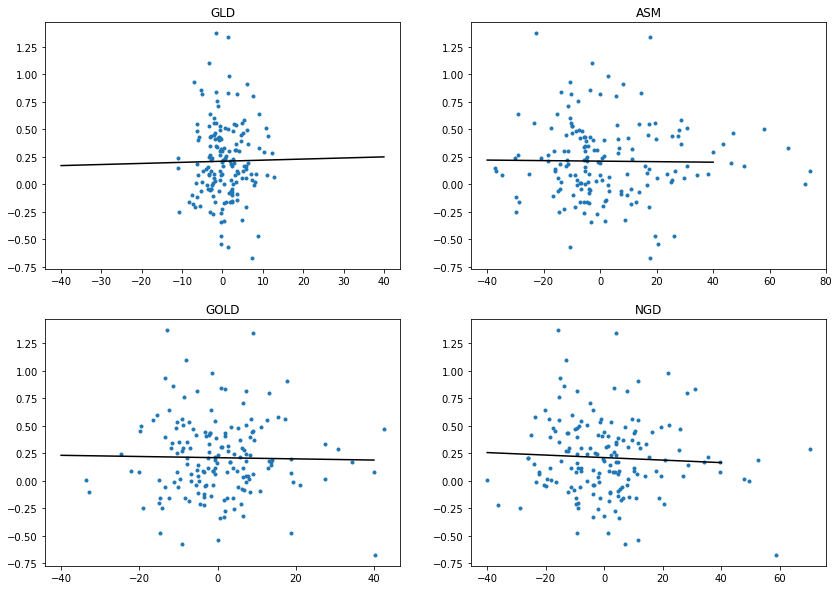

In [7]:
x_lr = np.linspace(-40,40)
ticker_pos = 0
fig,axs = plt.subplots(2,2,figsize=(14,10))
for x in range(2):
    for y in range(2):
        current_ticker = gold_list[ticker_pos]
        slope, intercept , r_value,p_value , std_err = linregress(df_returns[current_ticker],df_returns['CPI'])
        axs[x,y].plot(df_returns[current_ticker],df_returns['CPI'],'.')
        axs[x,y].set_title(current_ticker)        
        axs[x,y].plot(x_lr,slope * x_lr + intercept, 'k')
        ticker_pos += 1


### We coundn't find any trend between golds stocks and CPI

## We're going to analyze the price movements and its impact on CPI

   ### - Calculate the 20 days moving average for all gold stocks
   ### - Check by date how many stocks are above the moving average
   ### - Build a dataframe with "date" , "number of stocks result", "percent of stocks"
   ### - identify if the percent of stocks for each date has any impact on the index price movements
   ### - The idea would be see how much percent the CPI goes up or down when the percent of stock reach below zero

### 1 - Calculating the 20 moving average and also identify the number of stocks above the moving average by day

In [8]:
total_high = {}

for ticker in gold_list:
    df_tmp = pd.DataFrame(df_prices[ticker])
    df_tmp['MA200'] = df_tmp[ticker].rolling(20).mean()
    df_tmp['MMA200_high'] = np.where(df_tmp[ticker] > df_tmp['MA200'], 1, 0)
    df_tmp.dropna(inplace=True)
    for i,k in df_tmp.iterrows():
        if i not in total_high:
            if k['MMA200_high'] == 1:
                total_high[i] = 1
            else:
                total_high[i] = 0
        else:
            if k['MMA200_high'] == 1:
                total_high[i] += 1
            else:
                total_high[i] += 0               


### 2 - Creating a dataframe with the results of total_high and also adding a percent of stocks based on the quantity calculated before

In [9]:
final = pd.DataFrame()
final['date'] = total_high.keys()
final.set_index('date',inplace=True)
final['qty_high'] = total_high.values()
final['pct_high'] = round((final['qty_high'] / len(gold_list)) * 100,2)
final['CPI'] = round(df_prices['CPI'],2)
final['CPI_pct_changes'] = round(final['CPI'].pct_change() * 100,2)


### 3 - The chart will show how is the CPI changes agains the percent of stocks above the moving average


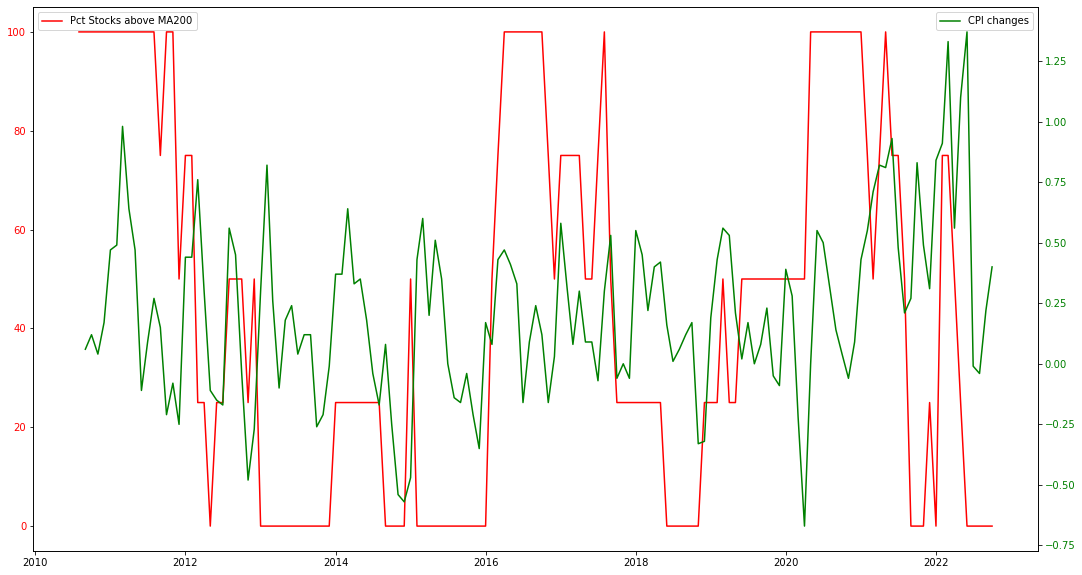

In [10]:
fig, ax = plt.subplots(figsize=(18,10))
ax.plot(final['pct_high'], color='red', label="Pct Stocks above MA200")
ax.tick_params(axis='y', labelcolor='red')
ax.legend(loc='upper left')

ax2 = ax.twinx()

ax2.plot(final['CPI_pct_changes'], color='green',label="CPI changes")
ax2.tick_params(axis='y', labelcolor='green')
plt.legend()

plt.show()

In [11]:
low_period = final[final['pct_high'] == 0]
high_period = final[final['pct_high'] == 100]



### 4 - Calculating how much percent CPI increases or decrease after the percent of stocks above the average is equal to 0

In [12]:
low_results = []
for i,k in low_period.iterrows():
        trading_period = []
        low_date = i
        future_date = low_date + dt.timedelta(days=130)
        trading_period = final.loc[low_date : future_date]
        if len(trading_period) > 0:
            begin_value = trading_period.iloc[0,trading_period.columns.get_loc('CPI')]
            end_value = trading_period.iloc[-1,trading_period.columns.get_loc('CPI')]
            low_results.append(round(((end_value - begin_value) / end_value) * 100,2))


In [13]:
print(f"AVG CPI change after 130 days: {round(sum(low_results) / len(low_results),3)}")


AVG CPI change after 130 days: 0.528


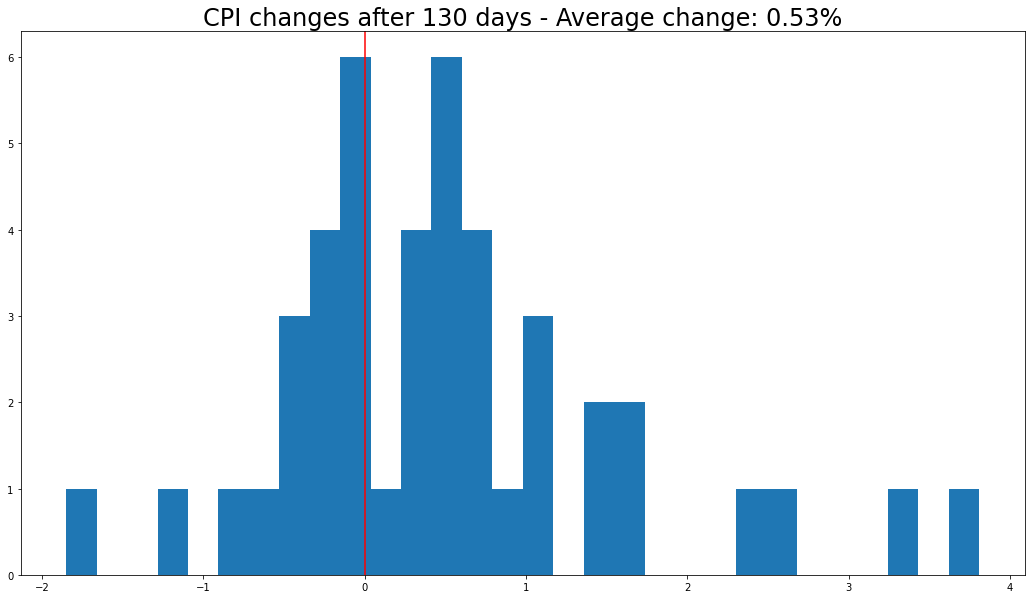

In [21]:
fig, ax = plt.subplots(figsize=(18,10))
ax.hist(low_results, bins=30)
ax.axvline(x = 0, color = 'r')
ax.set_title(f"CPI changes after 130 days - Average change: {round(sum(low_results) / len(low_results),2)}%", fontsize=24) 
plt.show()    

### 5 - Calculating how much percent CPI increases or decrease after the percent of stocks above the average is 100%

In [15]:
high_results = []
for i,k in high_period.iterrows():
        trading_period = []
        high_date = i
        future_date = high_date + dt.timedelta(days=130)
        trading_period = final.loc[high_date : future_date]
        if len(trading_period) > 0:
            begin_value = trading_period.iloc[0,trading_period.columns.get_loc('CPI')]
            end_value = trading_period.iloc[-1,trading_period.columns.get_loc('CPI')]
            high_results.append(round(((begin_value - end_value) / begin_value) * 100,2))


In [16]:
print(f"AVG CPI change after 130 days: {round(sum(high_results) / len(high_results),3)}")


AVG CPI change after 130 days: -1.017


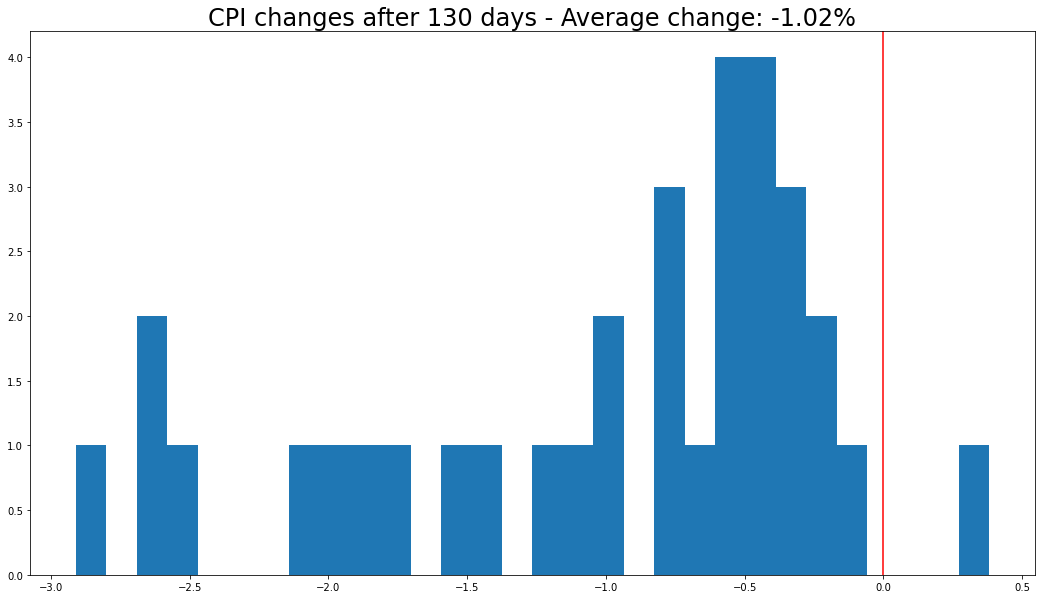

In [23]:
fig, ax = plt.subplots(figsize=(18,10))
ax.hist(high_results, bins=30)
ax.axvline(x = 0, color = 'r')


ax.set_title(f"CPI changes after 130 days - Average change: {round(sum(high_results) / len(high_results),2)}%", fontsize=24) 
plt.show()

    